### ANN with binary data - sentiment and stocks

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [2]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [3]:
df = pd.read_excel('LSTM_binary_170621.xlsx', header=0)

In [4]:
df.set_index('publication_date', inplace = True)

In [5]:
#create dummy sentiment variables
dummies = pd.get_dummies(df.sentiment, drop_first = True)
dummies

,0,1
publication_date,,
44257,0,1
44257,0,1
44201,1,0
42710,1,0
44174,0,1
...,...,...
42580,0,1
44041,0,0
44041,0,1


In [6]:
#add dummies to original df
df =pd.concat([df,dummies],axis=1)
df

,company_ticker,market_cap_mio_chf,mid_or_small,document_name,document_type,source,original_text,flesch_score,wiener_score,sentiment,...,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,0,1
publication_date,,,,,,,,,,,,,,,,,,,,,
44257,ARBN,1198,small_cap,ARBN_02.03.2021.txt,news,cash.ch,Der Bauzulieferer Arbonia hat im vergangenen G...,43.880769,11.839886,1,...,1,1,-1,1,-1,1,1,1,0,1
44257,ARBN,1198,small_cap,ARBN_02.03.2021_2.txt,news,cash.ch,Die Aktien von Arbonia legen am Dienstag klar ...,48.471429,10.630978,1,...,1,1,-1,1,-1,1,1,1,0,1
44201,ARBN,1198,small_cap,ARBN_05.01.2021.txt,news,cash.ch,Der Verkauf des Fenstergeschäfts hat der Arbon...,30.957143,13.276634,0,...,1,1,1,-1,1,1,-1,-1,1,0
42710,ARBN,1198,small_cap,ARBN_06.12.2016.txt,news,cash.ch,Der Bauzulieferer AFG Arbonia Forster hat im R...,39.566667,16.064963,0,...,0,1,1,1,-1,1,1,-1,1,0
44174,ARBN,1198,small_cap,ARBN_09.12.2020.txt,news,cash.ch,Beim Bauausrüster Arbonia hat sich im zweiten ...,53.879167,10.673042,1,...,1,1,1,-1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42580,ZEHN,972,small_cap,zehn_29.07.2016.txt,quarterly_earnings_report,company,Umsatzsteigerung und Ergebnisverbesserung. Die...,46.597119,11.132120,1,...,1,1,1,1,-1,-1,-1,1,0,1
44041,ZEHN,972,small_cap,ZEHN_29.07.2020 (2).txt,news,cash.ch,Zehnder übertrifft Erwartungen deutlich. Die a...,58.866667,9.486783,-1,...,1,-1,-1,1,-1,-1,1,-1,0,0
44041,ZEHN,972,small_cap,ZEHN_29.07.2020.txt,news,cash.ch,Zehnder-Aktien legen kräftig zu - Halbjahresza...,38.060164,12.875756,1,...,1,-1,-1,1,-1,-1,1,-1,0,1


In [7]:
#define y variable
y = df['t+0']
#replace -1 with 0
y = y.replace(-1,0)

In [8]:
x1 = df.iloc[:,12:]
x2 = df.iloc[:,-2:]

In [9]:
x1.head()

,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,...,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,0,1
publication_date,,,,,,,,,,,,,,,,,,,,,
44257,1,0,1,1,1,1,1,-1,-1,1,...,1,1,-1,1,-1,1,1,1,0,1
44257,1,0,1,1,1,1,1,-1,-1,1,...,1,1,-1,1,-1,1,1,1,0,1
44201,1,0,1,-1,1,-1,-1,1,0,-1,...,1,1,1,-1,1,1,-1,-1,1,0
42710,1,-1,1,1,0,-1,1,1,1,-1,...,0,1,1,1,-1,1,1,-1,1,0
44174,-1,1,1,-1,-1,-1,-1,1,1,0,...,1,1,1,-1,1,1,1,1,0,1


In [10]:
x1 = x1.values

In [11]:
print(x1.shape)

(662, 22)


In [12]:
x1.reshape(662, 1, 22)

array([[[ 1,  0,  1, ...,  1,  0,  1]],

       [[ 1,  0,  1, ...,  1,  0,  1]],

       [[ 1,  0,  1, ..., -1,  1,  0]],

       ...,

       [[-1, -1, -1, ..., -1,  0,  1]],

       [[-1, -1, -1, ..., -1,  0,  1]],

       [[-1,  1,  1, ...,  1,  1,  0]]], dtype=int64)

In [13]:
#y as np array
y = y.values

In [14]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x1, y, random_state = 2)

In [15]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(X_train)

sc_predict = StandardScaler()
sc_predict.fit_transform(X_test)

array([[-1.23156014, -1.03697099, -0.92756813, ..., -1.04041871,
        -0.66594163, -1.27864015],
       [ 0.85455193,  0.98817235, -0.92756813, ..., -1.04041871,
         1.5016331 , -1.27864015],
       [-1.23156014,  0.98817235, -0.92756813, ..., -1.04041871,
        -0.66594163,  0.78208087],
       ...,
       [ 0.85455193,  0.98817235, -0.92756813, ...,  1.00348077,
         1.5016331 , -1.27864015],
       [ 0.85455193,  0.98817235,  1.11185318, ..., -1.04041871,
        -0.66594163,  0.78208087],
       [ 0.85455193,  0.98817235, -0.92756813, ...,  1.00348077,
        -0.66594163,  0.78208087]])

In [16]:
X_train.shape

(496, 22)

In [17]:
y_train.shape

(496,)

In [18]:
# Import Libraries and packages from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Initializing the Neural Network 
model = Sequential([
    tf.keras.layers.Dense(22, input_shape = (X_train.shape[1],)),#only indicate nr. of columns
    
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='binary_crossentropy', metrics = ['accuracy'])



In [21]:
#train model using 0.2 val split
#%%time
history = model.fit(X_train, y_train, shuffle=False, epochs=200, validation_split=0.2, verbose=1, batch_size=256, )

Epoch 1/200
2/2 [==============================] - 0s 91ms/step - loss: 0.7703 - accuracy: 0.5101 - val_loss: 1.2009 - val_accuracy: 0.4200
Epoch 2/200
2/2 [==============================] - 0s 10ms/step - loss: 0.9237 - accuracy: 0.4722 - val_loss: 0.7149 - val_accuracy: 0.5700
Epoch 3/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6906 - accuracy: 0.5783 - val_loss: 0.7196 - val_accuracy: 0.5700
Epoch 4/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6749 - accuracy: 0.5884 - val_loss: 0.6723 - val_accuracy: 0.5700
Epoch 5/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6448 - accuracy: 0.6566 - val_loss: 0.6747 - val_accuracy: 0.5600
Epoch 6/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6366 - accuracy: 0.6439 - val_loss: 0.6850 - val_accuracy: 0.5900
Epoch 7/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6152 - accuracy: 0.6843 - val_loss: 0.6904 - val_accuracy: 0.6000
Epoch 8/200
2/2 [===

Epoch 59/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0828 - accuracy: 0.9773 - val_loss: 1.2023 - val_accuracy: 0.7700
Epoch 60/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0702 - accuracy: 0.9747 - val_loss: 1.2233 - val_accuracy: 0.7700
Epoch 61/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0757 - accuracy: 0.9646 - val_loss: 1.1711 - val_accuracy: 0.7700
Epoch 62/200
2/2 [==============================] - 0s 10ms/step - loss: 0.1226 - accuracy: 0.9571 - val_loss: 1.1716 - val_accuracy: 0.7300
Epoch 63/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0692 - accuracy: 0.9848 - val_loss: 1.1668 - val_accuracy: 0.7400
Epoch 64/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0526 - accuracy: 0.9823 - val_loss: 1.1224 - val_accuracy: 0.7700
Epoch 65/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0803 - accuracy: 0.9722 - val_loss: 1.1513 - val_accuracy: 0.7600
Epoch 66/200


2/2 [==============================] - 0s 10ms/step - loss: 0.0610 - accuracy: 0.9798 - val_loss: 1.9670 - val_accuracy: 0.7700
Epoch 118/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0277 - accuracy: 0.9899 - val_loss: 2.1316 - val_accuracy: 0.7800
Epoch 119/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0319 - accuracy: 0.9848 - val_loss: 2.1901 - val_accuracy: 0.7700
Epoch 120/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0925 - accuracy: 0.9823 - val_loss: 1.9835 - val_accuracy: 0.7700
Epoch 121/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0420 - accuracy: 0.9823 - val_loss: 1.9385 - val_accuracy: 0.7500
Epoch 122/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0618 - accuracy: 0.9798 - val_loss: 1.8426 - val_accuracy: 0.7600
Epoch 123/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0819 - accuracy: 0.9697 - val_loss: 1.8047 - val_accuracy: 0.7500
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0246 - accuracy: 0.9899 - val_loss: 2.0694 - val_accuracy: 0.7300
Epoch 176/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0190 - accuracy: 0.9975 - val_loss: 2.1684 - val_accuracy: 0.7700
Epoch 177/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0167 - accuracy: 0.9975 - val_loss: 2.2300 - val_accuracy: 0.7600
Epoch 178/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0112 - accuracy: 0.9975 - val_loss: 2.2493 - val_accuracy: 0.7700
Epoch 179/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0112 - accuracy: 0.9924 - val_loss: 2.2765 - val_accuracy: 0.7700
Epoch 180/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0439 - accuracy: 0.9823 - val_loss: 2.2392 - val_accuracy: 0.7600
Epoch 181/200
2/2 [==============================] - 0s 5ms/step - loss: 0.0255 - accuracy: 0.9899 - val_loss: 2.3245 - val_accuracy: 0.7600
Epoch 1

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 3.9550 - accuracy: 0.7108


In [23]:
#count value frequency in y_train
unique, counts = np.unique(y_train, return_counts=True)

print (np.asarray((unique, counts)).T)
print('Accuracy if only prediction ones:', (np.asarray((unique, counts)).T)[1][1] / ((np.asarray((unique, counts)).T)[0][1] + (np.asarray((unique, counts)).T)[1][1] ) )

[[  0 219]
 [  1 277]]
Accuracy if only prediction ones: 0.5584677419354839


In [24]:
#count value frequency in y_test and set prediction baseline minimum performance
unique, counts = np.unique(y_test, return_counts=True)

print (np.asarray((unique, counts)).T)
print('Accuracy if only prediction ones:', (np.asarray((unique, counts)).T)[1][1] / ((np.asarray((unique, counts)).T)[0][1] + (np.asarray((unique, counts)).T)[1][1] ) )

[[ 0 67]
 [ 1 99]]
Accuracy if only prediction ones: 0.5963855421686747


In [25]:
y_pred = (model.predict(X_test))

In [26]:
y_pred

array([[1.40454113e-01],
       [9.79506969e-03],
       [9.99997377e-01],
       [6.60569776e-06],
       [2.89005041e-03],
       [5.86594606e-10],
       [1.40540097e-11],
       [3.34382057e-04],
       [7.52776861e-04],
       [1.00000000e+00],
       [8.85810447e-09],
       [1.40173733e-02],
       [1.00000000e+00],
       [3.37299168e-01],
       [1.49786472e-04],
       [9.99754727e-01],
       [1.27938529e-06],
       [9.97928858e-01],
       [6.00146949e-02],
       [1.00000000e+00],
       [1.76812857e-01],
       [1.00000000e+00],
       [9.99144435e-01],
       [3.54975462e-04],
       [3.31357658e-01],
       [7.81309518e-06],
       [9.99999404e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [7.42663980e-01],
       [2.96562910e-04],
       [7.73543119e-03],
       [8.64839531e-05],
       [3.44479084e-03],
       [1.00000000e+00],
       [1.00000000e+00],
       [3.61680984e-04],
       [1.36062690e-05],
       [9.95972872e-01],
       [9.88605618e-01],


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

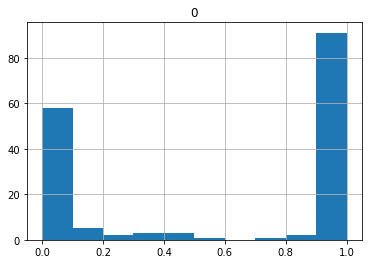

In [27]:
#plot predictions
y_pred_plot = pd.DataFrame(y_pred)
y_pred_plot.hist()

In [28]:
#define cutoff for predictions at naive 0.5
cutoff = (y_pred_plot > 0.50) *1

Accuracy score of: 0.7108433734939759


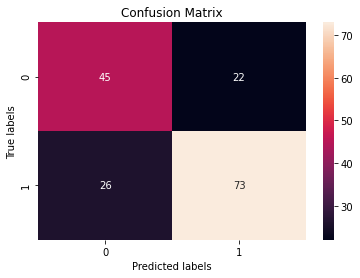

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, cutoff, labels=[0, 1,])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

print('Accuracy score of:' ,accuracy_score(y_test, cutoff))

In [30]:
from sklearn.metrics import classification_report
target_names = ['0','1']
print(classification_report(y_test, cutoff, target_names=target_names))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65        67
           1       0.77      0.74      0.75        99

    accuracy                           0.71       166
   macro avg       0.70      0.70      0.70       166
weighted avg       0.71      0.71      0.71       166



In [31]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, cutoff)

0.4056054838627975

### Same model with only stock data, no sentiment

In [32]:
df = pd.read_excel('LSTM_binary_170621.xlsx', header=0)

In [33]:
df.set_index('publication_date', inplace = True)

In [34]:
y = df['t+0']
y = y.replace(-1,0)

In [35]:
x1 = df.iloc[:,12:]

x1.head()


,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20
publication_date,,,,,,,,,,,,,,,,,,,,
44257,1,0,1,1,1,1,1,-1,-1,1,-1,-1,1,1,-1,1,-1,1,1,1
44257,1,0,1,1,1,1,1,-1,-1,1,-1,-1,1,1,-1,1,-1,1,1,1
44201,1,0,1,-1,1,-1,-1,1,0,-1,1,1,1,1,1,-1,1,1,-1,-1
42710,1,-1,1,1,0,-1,1,1,1,-1,0,1,0,1,1,1,-1,1,1,-1
44174,-1,1,1,-1,-1,-1,-1,1,1,0,-1,0,1,1,1,-1,1,1,1,1


In [36]:
x1 = x1.values


print(x1.shape)

(662, 20)


In [37]:
y = y.values

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x1, y, random_state = 2)

X_train.shape

y_train.shape

(496,)

In [39]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(X_train)

sc_predict = StandardScaler()
sc_predict.fit_transform(X_test)

array([[-1.23156014, -1.03697099, -0.92756813, ..., -0.17553565,
         0.99722638, -1.04041871],
       [ 0.85455193,  0.98817235, -0.92756813, ...,  0.86514   ,
        -1.0339341 , -1.04041871],
       [-1.23156014,  0.98817235, -0.92756813, ...,  0.86514   ,
        -1.0339341 , -1.04041871],
       ...,
       [ 0.85455193,  0.98817235, -0.92756813, ...,  0.86514   ,
        -1.0339341 ,  1.00348077],
       [ 0.85455193,  0.98817235,  1.11185318, ...,  0.86514   ,
        -1.0339341 , -1.04041871],
       [ 0.85455193,  0.98817235, -0.92756813, ..., -1.21621131,
         0.99722638,  1.00348077]])

In [40]:
# Import Libraries and packages from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam


# Initializing the Neural Network based on LSTM
model = Sequential([
    tf.keras.layers.Dense(20, input_shape = (X_train.shape[1],),kernel_regularizer='l2'),#only indicate nr. of columns
    
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
# Output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='binary_crossentropy', metrics = ['accuracy'])



In [41]:
%%time

history = model.fit(X_train, y_train, shuffle=False, epochs=200, validation_split=0.2, verbose=1, batch_size=256, )


Epoch 1/200
2/2 [==============================] - 0s 75ms/step - loss: 0.9803 - accuracy: 0.4672 - val_loss: 0.8702 - val_accuracy: 0.5800
Epoch 2/200
2/2 [==============================] - 0s 10ms/step - loss: 0.8658 - accuracy: 0.5480 - val_loss: 0.8424 - val_accuracy: 0.5800
Epoch 3/200
2/2 [==============================] - 0s 10ms/step - loss: 0.8388 - accuracy: 0.5530 - val_loss: 0.8177 - val_accuracy: 0.5800
Epoch 4/200
2/2 [==============================] - 0s 10ms/step - loss: 0.8150 - accuracy: 0.5530 - val_loss: 0.7959 - val_accuracy: 0.5800
Epoch 5/200
2/2 [==============================] - 0s 10ms/step - loss: 0.7940 - accuracy: 0.5530 - val_loss: 0.7769 - val_accuracy: 0.5800
Epoch 6/200
2/2 [==============================] - 0s 10ms/step - loss: 0.7757 - accuracy: 0.5530 - val_loss: 0.7605 - val_accuracy: 0.5800
Epoch 7/200
2/2 [==============================] - 0s 5ms/step - loss: 0.7599 - accuracy: 0.5530 - val_loss: 0.7463 - val_accuracy: 0.5800
Epoch 8/200
2/2 [====

2/2 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.5530 - val_loss: 0.6829 - val_accuracy: 0.5800
Epoch 60/200
2/2 [==============================] - 0s 6ms/step - loss: 0.6877 - accuracy: 0.5530 - val_loss: 0.6829 - val_accuracy: 0.5800
Epoch 61/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6877 - accuracy: 0.5530 - val_loss: 0.6829 - val_accuracy: 0.5800
Epoch 62/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6877 - accuracy: 0.5530 - val_loss: 0.6829 - val_accuracy: 0.5800
Epoch 63/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6877 - accuracy: 0.5530 - val_loss: 0.6829 - val_accuracy: 0.5800
Epoch 64/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6877 - accuracy: 0.5530 - val_loss: 0.6829 - val_accuracy: 0.5800
Epoch 65/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6877 - accuracy: 0.5530 - val_loss: 0.6829 - val_accuracy: 0.5800
Epoch 66/200
2/2 [==========

2/2 [==============================] - 0s 10ms/step - loss: 0.6022 - accuracy: 0.7500 - val_loss: 0.6819 - val_accuracy: 0.6400
Epoch 118/200
2/2 [==============================] - 0s 15ms/step - loss: 0.6098 - accuracy: 0.7348 - val_loss: 0.6701 - val_accuracy: 0.6900
Epoch 119/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6270 - accuracy: 0.7197 - val_loss: 0.6745 - val_accuracy: 0.6700
Epoch 120/200
2/2 [==============================] - 0s 15ms/step - loss: 0.6329 - accuracy: 0.7197 - val_loss: 0.6595 - val_accuracy: 0.6700
Epoch 121/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6186 - accuracy: 0.7197 - val_loss: 0.6546 - val_accuracy: 0.6700
Epoch 122/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6240 - accuracy: 0.7247 - val_loss: 0.6916 - val_accuracy: 0.6600
Epoch 123/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6144 - accuracy: 0.7348 - val_loss: 0.6896 - val_accuracy: 0.6500
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6346 - accuracy: 0.7071 - val_loss: 0.7802 - val_accuracy: 0.5900
Epoch 176/200
2/2 [==============================] - 0s 8ms/step - loss: 0.6521 - accuracy: 0.6970 - val_loss: 0.7862 - val_accuracy: 0.5800
Epoch 177/200
2/2 [==============================] - 0s 12ms/step - loss: 0.6276 - accuracy: 0.7071 - val_loss: 0.8017 - val_accuracy: 0.5700
Epoch 178/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6174 - accuracy: 0.7222 - val_loss: 0.7658 - val_accuracy: 0.6000
Epoch 179/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6211 - accuracy: 0.7172 - val_loss: 0.7694 - val_accuracy: 0.5900
Epoch 180/200
2/2 [==============================] - 0s 10ms/step - loss: 0.6228 - accuracy: 0.7146 - val_loss: 0.7834 - val_accuracy: 0.5700
Epoch 181/200
2/2 [==============================] - 0s 5ms/step - loss: 0.6330 - accuracy: 0.7071 - val_loss: 0.7497 - val_accuracy: 0.6100
Epoch 18

In [42]:
test_loss, test_acc = model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.7292 - accuracy: 0.6325


In [43]:
unique, counts = np.unique(y_train, return_counts=True)

print (np.asarray((unique, counts)).T)

[[  0 219]
 [  1 277]]


In [44]:
unique, counts = np.unique(y_test, return_counts=True)

print (np.asarray((unique, counts)).T)

[[ 0 67]
 [ 1 99]]


In [45]:
y_pred = (model.predict(X_test))
#model only predicts 1s
y_pred

array([[0.11901408],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.631917  ],
       [0.11901408],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.11913627],
       [0.6321761 ],
       [0.6321761 ],
       [0.11901408],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.63217604],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.11901408],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.55886924],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.6321761 ],
       [0.632

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

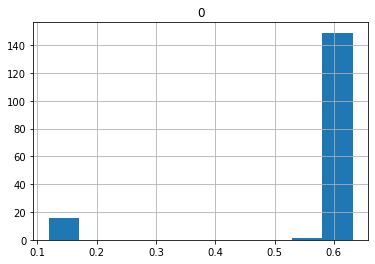

In [46]:
y_pred_plot = pd.DataFrame(y_pred)
y_pred_plot.hist()

In [47]:
cutoff = (y_pred_plot > 0.5) *1

Accuracy score of: 0.6325301204819277


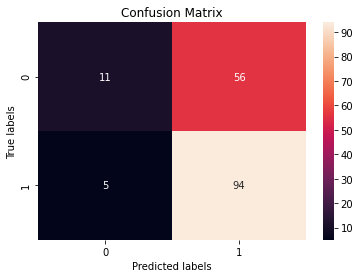

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, cutoff, labels=[0, 1,])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

print('Accuracy score of:' ,accuracy_score(y_test, cutoff))

In [49]:
from sklearn.metrics import classification_report
target_names = ['0','1']
print(classification_report(y_test, cutoff, target_names=target_names))

              precision    recall  f1-score   support

           0       0.69      0.16      0.27        67
           1       0.63      0.95      0.76        99

    accuracy                           0.63       166
   macro avg       0.66      0.56      0.51       166
weighted avg       0.65      0.63      0.56       166



In [50]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, cutoff)

0.18897777282804024